# Building the ML dataframe

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

In [3]:
# Set max number of columns to display; default 20
pd.options.display.max_columns = 80

In [4]:
# Directory where data files will be downloaded
cwd_path = Path.cwd()
data_path = cwd_path.parent.joinpath('data')
data_push_path = cwd_path.parent.joinpath('data_to_push')

#### Load in latest wind turbine data
- Note: Only 9 turbines decommissioned before 2019!

In [375]:
# Read in latest turbine data
# Now only 30,642 after removing 3 turbines outside bounding box
df_turbines = pd.read_pickle(data_push_path / 'df_turbines_knn_blades_haversine_elevation_utc.pkl')
df_turbines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30642 entries, 0 to 30641
Data columns (total 30 columns):
 #   Column                                            Non-Null Count  Dtype              
---  ------                                            --------------  -----              
 0   EinheitMastrNummer                                30642 non-null  object             
 1   DatumLetzteAktualisierung                         30642 non-null  datetime64[ns, UTC]
 2   Bundesland                                        30642 non-null  object             
 3   Postleitzahl                                      30642 non-null  int64              
 4   Ort                                               30642 non-null  object             
 5   Laengengrad                                       30642 non-null  float64            
 6   Breitengrad                                       30642 non-null  float64            
 7   Registrierungsdatum                               30642 non-null  d

In [376]:
# List of datetime column names for convenient indexing later
turbine_date_columns = [
    'DatumLetzteAktualisierung',
    'Registrierungsdatum',
    'Inbetriebnahmedatum',
    'DatumEndgueltigeStilllegung',
    'DatumBeginnVoruebergehendeStilllegung',
    'DatumWiederaufnahmeBetrieb'
]

In [371]:
# # Cast all tz naive datetime64 columns to UTC tz aware
# df_turbines[turbine_date_columns] = df_turbines[turbine_date_columns].apply(lambda series: series.dt.tz_localize('UTC'), axis=0)

# # save to pickle
# df_turbines.to_pickle(data_push_path / 'df_turbines_knn_blades_haversine_elevation_utc.pkl')

#### Load in SMARD data

In [159]:
# Get all SMARD CSV files, load into dataframes, and concat them

def load_SMARD_data():
    """
    Look for CSV files in the SMARD directory
    """
    list_of_dataframes = []
    for filepath in data_path.joinpath('SMARD').iterdir():
        if filepath.name.startswith('Realisierte_Erzeugung'):
            list_of_dataframes.append(pd.read_csv(filepath, sep=';'))
            
    # Check that num of rows is what I expect after concatenating dfs
    num_of_rows = 0
    for df in list_of_dataframes:
        num_of_rows += len(df)
    
    # concat dataframes
    df = pd.concat(list_of_dataframes)
    
    # Select columns to keep
    # Note: I'm using the interval start time to create the timestamps
    # ERA5 surface parameters are instantaneous so can't perfectly align anyway
    df = df[[
        'Datum',
        'Anfang',
        # 'Ende',
        'Wind Onshore [MWh] Berechnete Auflösungen'
    ]]
    
    # rename columns
    df.rename(columns={
        'Datum': 'date',
        'Anfang': 'interval_start_time', 
        # 'Ende': 'interval_end_time',
        'Wind Onshore [MWh] Berechnete Auflösungen': 'onshore_generated_mwh'
    }, inplace=True)
    
    # Handle dates and times to create unified datetime64 timestamps
    df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
    df['start_time_delta'] = pd.to_timedelta(df['interval_start_time'] + ':00')
    df['datetime_cet'] = df['date'] + df['start_time_delta']
    # Add CET timezone info and infer change from CET->CEST->CET, etc
    df['datetime_cet'] = df['datetime_cet'].dt.tz_localize(tz='CET', ambiguous='infer')
    
    # Drop un-needed columns
    df = df.drop(columns=['date', 'start_time_delta', 'interval_start_time'])
    # Re-arrange columns
    df = df[['datetime_cet', 'onshore_generated_mwh']]
    
    # Convert European thousands and decimal seperators in values to (US/UK) decimal full stop format
    translation_table = str.maketrans({'.': None, ',': '.'})
    df['onshore_generated_mwh'] = df['onshore_generated_mwh'].str.translate(translation_table).astype(float)
    
    print(f'Number of rows match up: {num_of_rows == len(df)}')
    
    return df.copy()

In [161]:
# Load SMARD data
df_smard = load_SMARD_data()
df_smard.info()

Number of rows match up: True
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   datetime_cet           8760 non-null   datetime64[ns, CET]
 1   onshore_generated_mwh  8760 non-null   float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 137.0 KB


In [162]:
# df_smard[df_smard['datetime'] < pd.Timestamp('2022-10-30')]

In [163]:
df_smard.head(3)

,datetime_cet,onshore_generated_mwh
0,2022-01-01 00:00:00+01:00,25487.75
1,2022-01-01 01:00:00+01:00,24280.50
2,2022-01-01 02:00:00+01:00,23114.00


-----

## Begin building ML dataframe `df_main`
- Start with one full year: 2022
    - Then bring in another year like 2021 and run through the same transformations and then concat along datetimeindex?
- Good resource on time-related feature engineering: https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html

In [617]:
# Year 2022
# Make time zone aware UTC?
datetime_index_utc = pd.date_range(start='2022-01-01', end='2022-12-31 23:59:59', freq='H', name='datetime_utc', tz='UTC')

# Make index to dataframe and reset
df_main = datetime_index_utc.to_frame().reset_index(drop=True)

# Extract properties and derive new columns
df_main['hour'] = df_main['datetime_utc'].dt.hour
# 0-6 (Monday-Sunday)
df_main['day_of_week'] = df_main['datetime_utc'].dt.dayofweek
df_main['day_of_month'] = df_main['datetime_utc'].dt.day
df_main['month_number'] = df_main['datetime_utc'].dt.month

# Function to get meteorological season based on month number (1-12)
# Should I just go ahead and encode the discrete numerical value?
def get_meteorological_season(month):
    if 3 <= month <= 5:
        return 'spring'
    elif 6 <= month <= 8:
        return 'summer'
    elif 9 <= month <= 11:
        return 'autumn'
    else:
        return 'winter'
    
df_main['meteorological_season'] = df_main['month_number'].apply(get_meteorological_season)

df_main

,datetime_utc,hour,day_of_week,day_of_month,month_number,meteorological_season
0,2022-01-01 00:00:00+00:00,0,5,1,1,winter
1,2022-01-01 01:00:00+00:00,1,5,1,1,winter
2,2022-01-01 02:00:00+00:00,2,5,1,1,winter
3,2022-01-01 03:00:00+00:00,3,5,1,1,winter
4,2022-01-01 04:00:00+00:00,4,5,1,1,winter
...,...,...,...,...,...,...
8755,2022-12-31 19:00:00+00:00,19,5,31,12,winter
8756,2022-12-31 20:00:00+00:00,20,5,31,12,winter
8757,2022-12-31 21:00:00+00:00,21,5,31,12,winter
8758,2022-12-31 22:00:00+00:00,22,5,31,12,winter


----

## Number of active turbines per hour and total active nominal power 
- convert all date columns in turbine df to UTC time zone aware! Then re-save to pkl. Does it keep the dtype?
    - Yes!

#### Function to check if turbine operational at a given UTC hour timestamp

In [618]:
def is_operational(timestamp_utc, df_turbines):
    """
    Inputs: hourly tz aware utc timestamps, turbine dataframe
    Get a bool series of turbines that are operational at the time of the [hourly] timestamp
    """
    # Turbines that went into operation before the timestamp; returns bool series for bool indexing
    started_operations = df_turbines['Inbetriebnahmedatum'] <= timestamp_utc

    # Turbines already decommissioned before the timestamp; returns bool series for bool indexing
    already_decommissioned = df_turbines['DatumEndgueltigeStilllegung'] <= timestamp_utc

    # Turbines that went into maintenance before timestamp and haven't come back into operation before the timestamp
    # Note: Some turbines go straight from temporary maintenance to decommissioned without ever going back into operation
    still_in_maintenance_or_decommissioned = (df_turbines['DatumBeginnVoruebergehendeStilllegung'] <= timestamp_utc) & \
    ((df_turbines['DatumWiederaufnahmeBetrieb'] > timestamp_utc) | df_turbines['DatumWiederaufnahmeBetrieb'].isna())

    # Number of turbines operational at the timestamp
    # Note the tildas to inverse these bool series
    # This is a bool series with df_turbines index
    turbines_in_operation_bool_series = (started_operations & ~already_decommissioned & ~still_in_maintenance_or_decommissioned)

    return turbines_in_operation_bool_series

In [619]:
df_main['turbines_in_operation'] = df_main['datetime_utc'].apply(lambda timestamp: is_operational(timestamp, df_turbines).sum())

In [620]:
# About 8s to run for all 8,760 hours in the year
# df_main = count_active_turbines(df_main, df_turbines)

In [621]:
# def count_active_turbines(df_main, df_turbines):
    
#     def is_operational(timestamp):
#         """
#         Get a bool series of turbines that are operational at the time of the [hourly] timestamp
#         """
#         # Turbines that went into operation before the timestamp; returns bool series for bool indexing
#         started_operations = df_turbines['Inbetriebnahmedatum'] <= timestamp
        
#         # Turbines already decommissioned before the timestamp; returns bool series for bool indexing
#         already_decommissioned = df_turbines['DatumEndgueltigeStilllegung'] <= timestamp
        
#         # Turbines that went into maintenance before timestamp and haven't come back into operation before the timestamp
#         # Note: Some turbines go straight from temporary maintenance to decommissioned without ever going back into operation
#         still_in_maintenance_or_decommissioned = (df_turbines['DatumBeginnVoruebergehendeStilllegung'] <= timestamp) & \
#         ((df_turbines['DatumWiederaufnahmeBetrieb'] > timestamp) | df_turbines['DatumWiederaufnahmeBetrieb'].isna())
        
#         # Number of turbines operational at the timestamp
#         # Note the tildas to inverse these bool series
#         # This is a bool series with .sum() counting the number of True
#         return (started_operations & ~already_decommissioned & ~still_in_maintenance_or_decommissioned).sum()
    
#     df_main['num_active_turbines'] = df_main['datetime_utc'].apply(is_operational)
    
#     # Return a copy
#     return df_main.copy()

In [622]:
df_main

,datetime_utc,hour,day_of_week,day_of_month,month_number,meteorological_season,turbines_in_operation
0,2022-01-01 00:00:00+00:00,0,5,1,1,winter,28965
1,2022-01-01 01:00:00+00:00,1,5,1,1,winter,28965
2,2022-01-01 02:00:00+00:00,2,5,1,1,winter,28965
3,2022-01-01 03:00:00+00:00,3,5,1,1,winter,28965
4,2022-01-01 04:00:00+00:00,4,5,1,1,winter,28965
...,...,...,...,...,...,...,...
8755,2022-12-31 19:00:00+00:00,19,5,31,12,winter,29262
8756,2022-12-31 20:00:00+00:00,20,5,31,12,winter,29262
8757,2022-12-31 21:00:00+00:00,21,5,31,12,winter,29262
8758,2022-12-31 22:00:00+00:00,22,5,31,12,winter,29262


<Axes: >

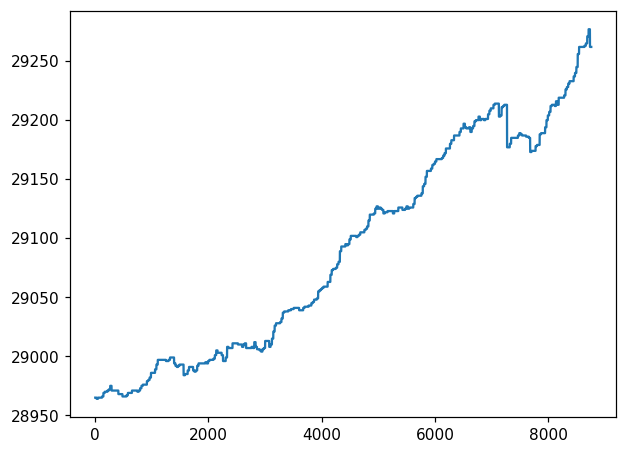

In [623]:
df_main['turbines_in_operation'].plot()

In [624]:
df_main['turbines_in_operation'].describe()

count     8760.000000
mean     29090.161644
std         91.452150
min      28964.000000
25%      29001.000000
50%      29093.000000
75%      29183.000000
max      29277.000000
Name: turbines_in_operation, dtype: float64

### Create derived column `total_nominal_capacity_operational_turbines`

In [625]:
df_main['total_nominal_capacity_operational_turbines_mwh'] = df_main['datetime_utc'].apply(
    lambda timestamp: df_turbines.loc[:, 'Nettonennleistung'].loc[is_operational(timestamp, df_turbines)].sum() / 1_000)

In [626]:
df_main

,datetime_utc,hour,day_of_week,day_of_month,month_number,meteorological_season,turbines_in_operation,total_nominal_capacity_operational_turbines_mwh
0,2022-01-01 00:00:00+00:00,0,5,1,1,winter,28965,55864.400147
1,2022-01-01 01:00:00+00:00,1,5,1,1,winter,28965,55864.400147
2,2022-01-01 02:00:00+00:00,2,5,1,1,winter,28965,55864.400147
3,2022-01-01 03:00:00+00:00,3,5,1,1,winter,28965,55864.400147
4,2022-01-01 04:00:00+00:00,4,5,1,1,winter,28965,55864.400147
...,...,...,...,...,...,...,...,...
8755,2022-12-31 19:00:00+00:00,19,5,31,12,winter,29262,57973.178937
8756,2022-12-31 20:00:00+00:00,20,5,31,12,winter,29262,57973.178937
8757,2022-12-31 21:00:00+00:00,21,5,31,12,winter,29262,57973.178937
8758,2022-12-31 22:00:00+00:00,22,5,31,12,winter,29262,57973.178937


-----

## Test merging SMARD label data onto `df` on key datetime

In [167]:
df_merged = pd.merge(df, df_smard, left_on='datetime_utc', right_on='datetime_cet', how='left')
df_merged

,datetime_utc,hour,day_of_week,day_of_month,month_number,meteorological_season,datetime_cet,onshore_generated_mwh
0,2022-01-01 00:00:00+00:00,0,5,1,1,winter,2022-01-01 01:00:00+01:00,24280.50
1,2022-01-01 01:00:00+00:00,1,5,1,1,winter,2022-01-01 02:00:00+01:00,23114.00
2,2022-01-01 02:00:00+00:00,2,5,1,1,winter,2022-01-01 03:00:00+01:00,21998.25
3,2022-01-01 03:00:00+00:00,3,5,1,1,winter,2022-01-01 04:00:00+01:00,20495.00
4,2022-01-01 04:00:00+00:00,4,5,1,1,winter,2022-01-01 05:00:00+01:00,19494.50
...,...,...,...,...,...,...,...,...
8755,2022-12-31 19:00:00+00:00,19,5,31,12,winter,2022-12-31 20:00:00+01:00,30505.00
8756,2022-12-31 20:00:00+00:00,20,5,31,12,winter,2022-12-31 21:00:00+01:00,30768.50
8757,2022-12-31 21:00:00+00:00,21,5,31,12,winter,2022-12-31 22:00:00+01:00,30490.75
8758,2022-12-31 22:00:00+00:00,22,5,31,12,winter,2022-12-31 23:00:00+01:00,29306.00


In [168]:
df_merged.head()

,datetime_utc,hour,day_of_week,day_of_month,month_number,meteorological_season,datetime_cet,onshore_generated_mwh
0,2022-01-01 00:00:00+00:00,0,5,1,1,winter,2022-01-01 01:00:00+01:00,24280.50
1,2022-01-01 01:00:00+00:00,1,5,1,1,winter,2022-01-01 02:00:00+01:00,23114.00
2,2022-01-01 02:00:00+00:00,2,5,1,1,winter,2022-01-01 03:00:00+01:00,21998.25
3,2022-01-01 03:00:00+00:00,3,5,1,1,winter,2022-01-01 04:00:00+01:00,20495.00
4,2022-01-01 04:00:00+00:00,4,5,1,1,winter,2022-01-01 05:00:00+01:00,19494.50


In [169]:
df_merged.isna().sum()

datetime_utc             0
hour                     0
day_of_week              0
day_of_month             0
month_number             0
meteorological_season    0
datetime_cet             1
onshore_generated_mwh    1
dtype: int64

In [170]:
df_merged[7240:].head(15)

,datetime_utc,hour,day_of_week,day_of_month,month_number,meteorological_season,datetime_cet,onshore_generated_mwh
7240,2022-10-29 16:00:00+00:00,16,5,29,10,autumn,2022-10-29 18:00:00+02:00,4657.25
7241,2022-10-29 17:00:00+00:00,17,5,29,10,autumn,2022-10-29 19:00:00+02:00,5988.25
7242,2022-10-29 18:00:00+00:00,18,5,29,10,autumn,2022-10-29 20:00:00+02:00,7333.25
7243,2022-10-29 19:00:00+00:00,19,5,29,10,autumn,2022-10-29 21:00:00+02:00,8419.00
7244,2022-10-29 20:00:00+00:00,20,5,29,10,autumn,2022-10-29 22:00:00+02:00,8901.00
7245,2022-10-29 21:00:00+00:00,21,5,29,10,autumn,2022-10-29 23:00:00+02:00,9505.25
7246,2022-10-29 22:00:00+00:00,22,5,29,10,autumn,2022-10-30 00:00:00+02:00,6546.50
7247,2022-10-29 23:00:00+00:00,23,5,29,10,autumn,2022-10-30 01:00:00+02:00,9525.50
7248,2022-10-30 00:00:00+00:00,0,6,30,10,autumn,2022-10-30 02:00:00+02:00,9475.50
7249,2022-10-30 01:00:00+00:00,1,6,30,10,autumn,2022-10-30 02:00:00+01:00,9311.25


-------

## Looking at other SMARD data like market price of electricity 

In [152]:
price = pd.read_csv(data_path.joinpath('SMARD') / 'Gro_handelspreise_202201010000_202212312359_Stunde.csv', sep=';')

In [164]:
translation_table = str.maketrans({'.': None, ',': '.'})
price['Deutschland/Luxemburg [€/MWh] Originalauflösungen'] = price['Deutschland/Luxemburg [€/MWh] Originalauflösungen'].str.translate(translation_table).astype(float)

In [166]:
price['Deutschland/Luxemburg [€/MWh] Originalauflösungen'].describe()

count    8760.000000
mean      235.446143
std       142.809409
min       -19.040000
25%       134.197500
50%       208.340000
75%       310.080000
max       871.000000
Name: Deutschland/Luxemburg [€/MWh] Originalauflösungen, dtype: float64